# internal wave dispersion relationship

See `argo_profiles.ipynb` notebook for more details about argo profiles.


In [1]:
from glob import glob

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import gsw

---
## load Argo data

In [4]:
data_dir = "argo/"
nc_files = glob(data_dir+"/*.nc")[:-1] # last files has issues don't know why
codes = [f.split("_")[-1].replace(".nc","") for f in nc_files]
print(codes)

['6902969', '6901250', '6902954', '3901849']


In [5]:
### utils 

hours = 3600
days = 86400

def load_nc(f):
    """ load argo file and massage
    """
    ds = xr.open_dataset(f)
    
    #print(f, ds)
        
    # required for profile plots (weird ...)
    ds = ds.transpose("DEPTH", "TIME", "LATITUDE", "LONGITUDE", "POSITION")    
    #
    ds = ds.assign_coords(z = -ds.DEPTH )
    ds["lon"] = ("TIME", ds.LONGITUDE.values)
    ds["lat"] = ("TIME", ds.LATITUDE.values)
    lon = ds.PRES*0 + ds.lon
    lat = ds.PRES*0 + ds.lat
    #
    ds["SA"] = gsw.SA_from_SP(ds.PSAL, ds.PRES, lon, lat) # absolute Salinity
    ds["CT"] = gsw.CT_from_t(ds.SA, ds.TEMP, ds.PRES) # conservative temperature
    ds["PT"] = gsw.pt_from_CT(ds.SA, ds.CT) # potential temperature
    ds["sigma0"] = gsw.sigma0(ds.SA, ds.CT)
    #
    N2, p_mid = gsw.Nsquared(ds.SA, ds.CT, ds.PRES, lat=0, axis=0)    
    #print(N2.shape, N2[:,1], p_mid[:,2])
    #z_mid = gsw.z_from_p(p_mid, ds.lat.values)
    #ds["DEPTH_MID"] = (("DEPTH_MID"), -np.nanmean(z_mid, axis=1))
    ds["DEPTH_MID"] = (("DEPTH_MID"), ds.DEPTH.values[:-1])
    ds = ds.assign_coords(z_mid=-ds.DEPTH_MID)
    ds["N2"] = (("DEPTH_MID", "TIME"), N2)
        
    # filter bad profiles (custom)
    flag = ds.PSAL.fillna(0).mean("DEPTH")
    ds = ds.where(flag>0, drop=True)
        
    return ds

def plot_profiles(ds):
    """ plot basic variables
    """

    fig, axes = plt.subplots(2,2, figsize=(10,10))
    _axes = axes.flatten()
    
    variables = ["PT", "SA", "sigma0", "N2"]
    for v, ax in zip(variables, _axes[:len(variables)]):
        da = ds[v]
        if "z" in da.coords:
            z_coord = "z"
        else:
            z_coord = "z_mid"
        da.plot.line(y=z_coord, add_legend=False, ax=ax)
        ax.grid()
        ax.set_xlabel("")
        ax.set_title(v)
    return axes

def smooth(ds, dz=50, depth_max=1000):
    """ smooth vertical profile """
    depth_bins = np.arange(0, depth_max, dz)
    depth = (depth_bins[:-1] + depth_bins[1:])*0.5
    _ds = (ds
          .groupby_bins("DEPTH", bins=depth_bins, labels=depth)
          .mean()
          .rename(DEPTH_bins="DEPTH")
          .drop(["N2", "z_mid", "DEPTH_MID"])
         )
    _ds = _ds.assign_coords(z=-_ds.DEPTH)
    #
    N2 = (ds["N2"]
          .groupby_bins("DEPTH_MID", bins=depth_bins, labels=depth)
          .mean()
          .rename(DEPTH_MID_bins="DEPTH_MID")
         )
    N2 = N2.assign_coords(z_mid=-N2.DEPTH_MID)
    #
    ds = xr.merge([N2, _ds])
    return ds

In [6]:
data = {int(c): load_nc(f) for f, c in zip(nc_files, codes)}

Data nearby the cable (from EuroArgo maps):

- Float 6901250 (cycles 137, 38)
- Float 6902969 (cycles 32)

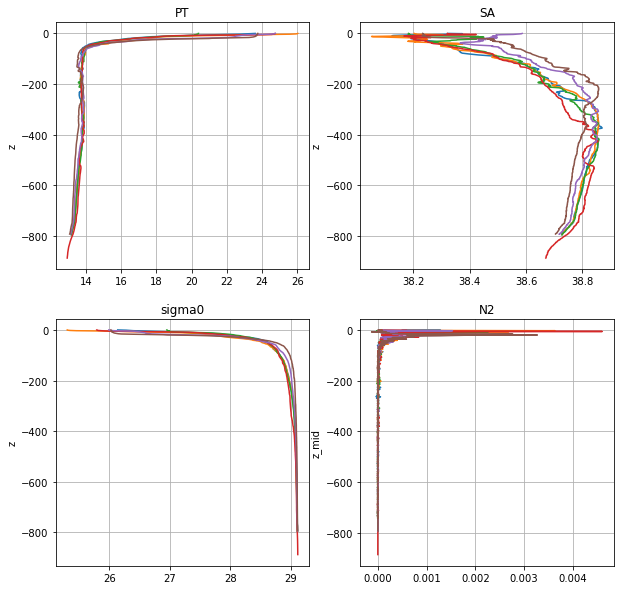

In [7]:
ds = data[6902969]
ds_smooth = smooth(ds)

plot_profiles(ds);

(13.0, 14.0)

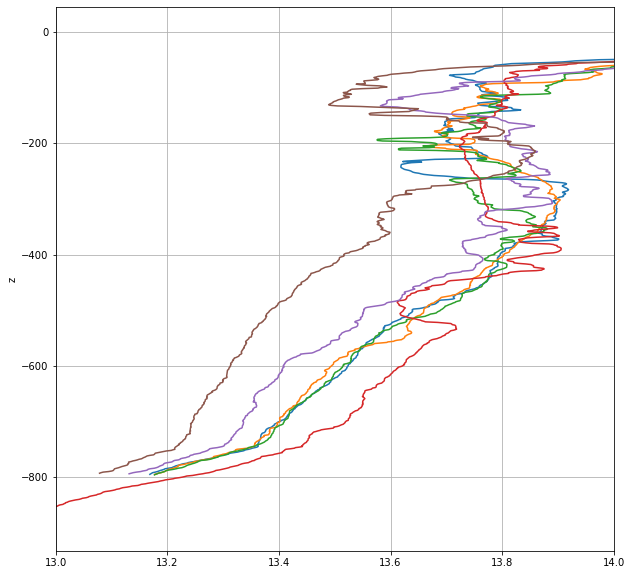

In [9]:
#axes = plot_profiles(ds)
#axes[0][0]

fig, ax = plt.subplots(1,1, figsize=(10,10))

_da = ds["PT"]

_da.plot.line(y="z", add_legend=False, ax=ax)
ax.grid()
ax.set_xlabel("")
#ax.set_title(v)
ax.set_xlim((13,14))
#ax.set_ylim()

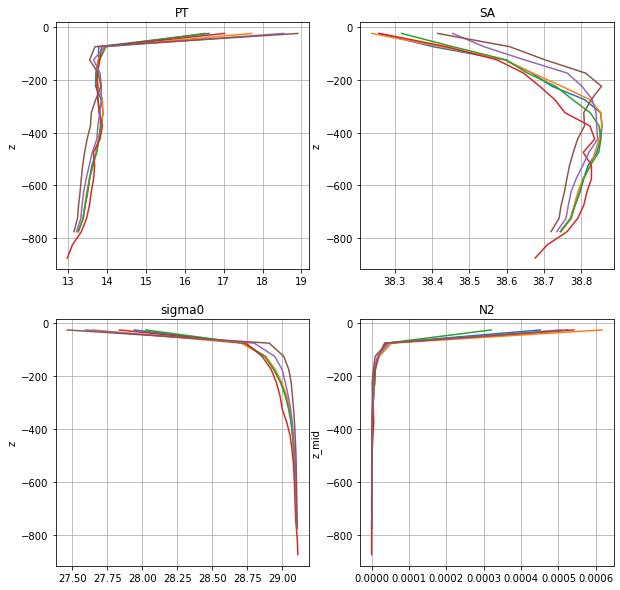

In [13]:
plot_profiles(ds_smooth);

(0.0, 1e-05)

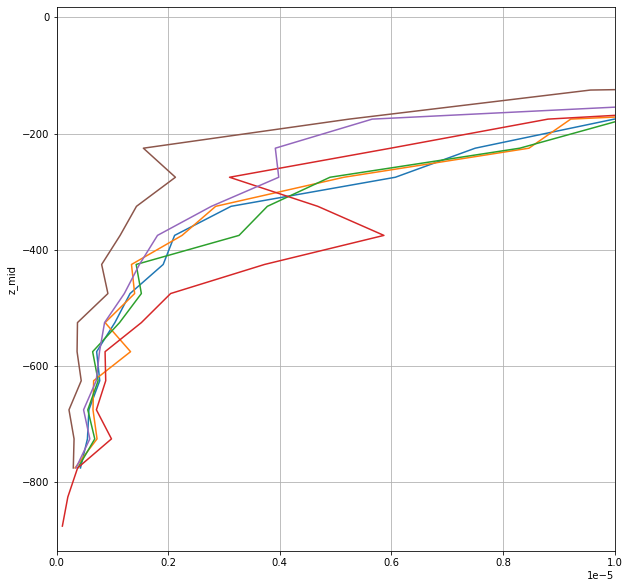

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

_da = ds["N2"]
_da = ds_smooth["N2"]

_da.plot.line(y="z_mid", add_legend=False, ax=ax)
ax.grid()
ax.set_xlabel("")
#ax.set_title(v)
ax.set_xlim((0,1e-5))
#ax.set_ylim()

Typical $N^2$ values are around $1-2 \times 10^{-6}$

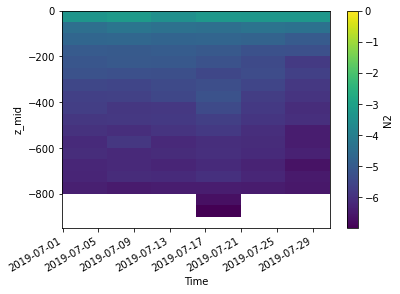

In [22]:
np.log10(ds_smooth.N2).plot(y="z_mid", vmax=0); # in cycles per hours

---

## dispersion relationship

$
\begin{align}
\frac{m^2}{k_h^2} = \frac{N^2-\omega^2}{\omega^2-f^2}
\end{align}
$


Text(0.5, 1.0, 'horizontal wavelength [km] \n f = 1.4 cpd (=17.6 hours), N = 13.8 cpd (=1.7 hours)')

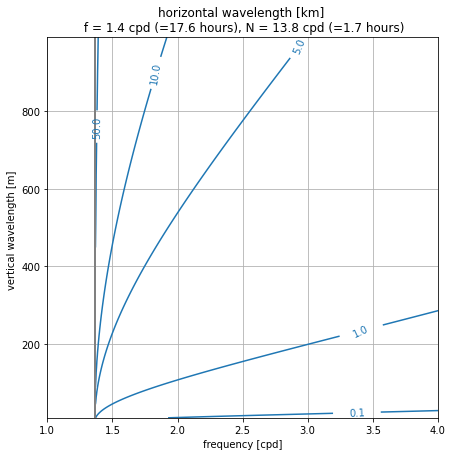

In [85]:
f = 2*2*np.pi/86400*np.sin(np.pi/180*43)
N2 = 1e-6
cph = 3600/(2*np.pi)
cpd = 86400/(2*np.pi)

N = np.sqrt(N2)

ds = xr.Dataset(coords=dict(Lz=("Lz", np.arange(10, 1000, 10)),
                            omega=("omega", np.linspace(f,N/2,1000)) 
                           )
               )
ds = ds.assign_coords(omega_cpd=ds.omega*cpd)

ds["m"] = 2*np.pi/ds.Lz
ds["kh"] = ds.m * np.sqrt((ds.omega**2 - f**2)/(N**2 - ds.omega**2))
ds["Lh"] = 2*np.pi/ds.kh


fig, ax = plt.subplots(1,1, figsize=(7,7))
CS = (ds.Lh/1e3).T.plot.contour(x="omega_cpd", colors="C0", 
                                levels=[.1, 1, 5, 10, 50],
                               ) # weird necessary transposition
ax.clabel(CS, inline=1, fontsize=10)
ax.axvline(f*cpd, color="0.5", lw=2)
ax.set_xlim(1,4)
ax.grid()
ax.set_xlabel("frequency [cpd]")
ax.set_ylabel("vertical wavelength [m] ")
ax.set_title(f"horizontal wavelength [km] \n f = {f*cpd:.1f} cpd (={1/f/cph:.1f} hours), N = {N*cpd:.1f} cpd (={1/N/cph:.1f} hours)")

---

## reflection against the bottom and bottom trapped waves
